<a href="https://colab.research.google.com/github/saichandrapandraju/TF-Developer/blob/main/4.%20Seq%20%2B%20Time%20series/3.%20dynamic_LR_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)

2.4.1


In [17]:
from tqdm.notebook import tqdm

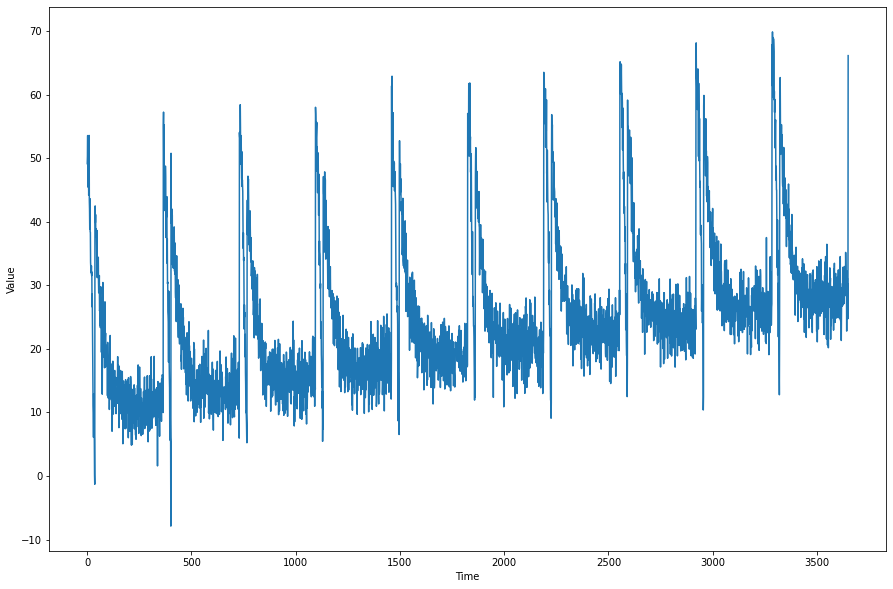

In [3]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(False)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.1,
                    np.cos(season_time * 6 * np.pi),
                    2 / np.exp(9 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(10 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)  
baseline = 10
amplitude = 40
slope = 0.005
noise_level = 3

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=51)

split_time = 3000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

plt.figure(figsize=(15, 10))
plot_series(time, series)

In [4]:
window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

In [5]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

In [6]:
tf.keras.backend.clear_session()
tf.random.set_seed(333)
np.random.seed(333)

tf.keras.backend.clear_session()
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), input_shape=[None]),  # NN's expect input in 3 dims ([batch_size, time_steps, dims]). for univariate timeseries, dims=1
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x*100) # above layers apply tanh activation function which shifts input to -1 to 1. as all inputs are <=100, multiplying with 100
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(dataset, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
94/94 [==============================] - 36s 10ms/step - loss: 14.6327 - mae: 15.1312
Epoch 2/100
94/94 [==============================] - 1s 9ms/step - loss: 9.0090 - mae: 9.4998
Epoch 3/100
94/94 [==============================] - 1s 9ms/step - loss: 6.9706 - mae: 7.4584
Epoch 4/100
94/94 [==============================] - 1s 10ms/step - loss: 6.1925 - mae: 6.6759
Epoch 5/100
94/94 [==============================] - 1s 9ms/step - loss: 5.9432 - mae: 6.4275
Epoch 6/100
94/94 [==============================] - 1s 10ms/step - loss: 5.6085 - mae: 6.0893
Epoch 7/100
94/94 [==============================] - 1s 10ms/step - loss: 5.5541 - mae: 6.0358
Epoch 8/100
94/94 [==============================] - 1s 10ms/step - loss: 5.5048 - mae: 5.9886
Epoch 9/100
94/94 [==============================] - 1s 9ms/step - loss: 5.1883 - mae: 5.6700
Epoch 10/100
94/94 [==============================] - 1s 10ms/step - loss: 4.9842 - mae: 5.4630
Epoch 11/100
94/94 [==============================

(1e-08, 0.0001, 2.0, 6.0)

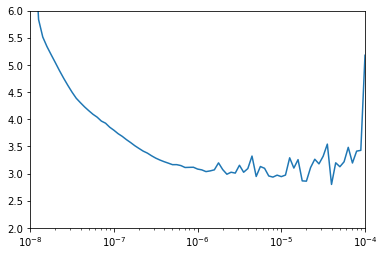

In [11]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 2, 6])

In [14]:
tf.keras.backend.clear_session()
tf.random.set_seed(333)
np.random.seed(333)

tf.keras.backend.clear_session()
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), input_shape=[None]),  # NN's expect input in 3 dims ([batch_size, time_steps, dims]). for univariate timeseries, dims=1
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x*100) # above layers apply tanh activation function which shifts input to -1 to 1. as all inputs are <=100, multiplying with 100
])

model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9), metrics=["mae"])
history = model.fit(dataset,epochs=500,verbose=1)
                                                            
# FIND A MODEL AND A LR THAT TRAINS TO AN MAE < 3                                                          

Epoch 1/500
94/94 [==============================] - 6s 10ms/step - loss: 124.1576 - mae: 8.2264
Epoch 2/500
94/94 [==============================] - 1s 9ms/step - loss: 33.6335 - mae: 4.0303
Epoch 3/500
94/94 [==============================] - 1s 9ms/step - loss: 30.2078 - mae: 3.7445
Epoch 4/500
94/94 [==============================] - 1s 9ms/step - loss: 23.8730 - mae: 3.4382
Epoch 5/500
94/94 [==============================] - 1s 9ms/step - loss: 25.3141 - mae: 3.4214
Epoch 6/500
94/94 [==============================] - 1s 9ms/step - loss: 29.2579 - mae: 3.7764
Epoch 7/500
94/94 [==============================] - 1s 9ms/step - loss: 25.5220 - mae: 3.4619
Epoch 8/500
94/94 [==============================] - 1s 9ms/step - loss: 25.7588 - mae: 3.4237
Epoch 9/500
94/94 [==============================] - 1s 9ms/step - loss: 22.4900 - mae: 3.3142
Epoch 10/500
94/94 [==============================] - 1s 9ms/step - loss: 26.1352 - mae: 3.4802
Epoch 11/500
94/94 [===========================

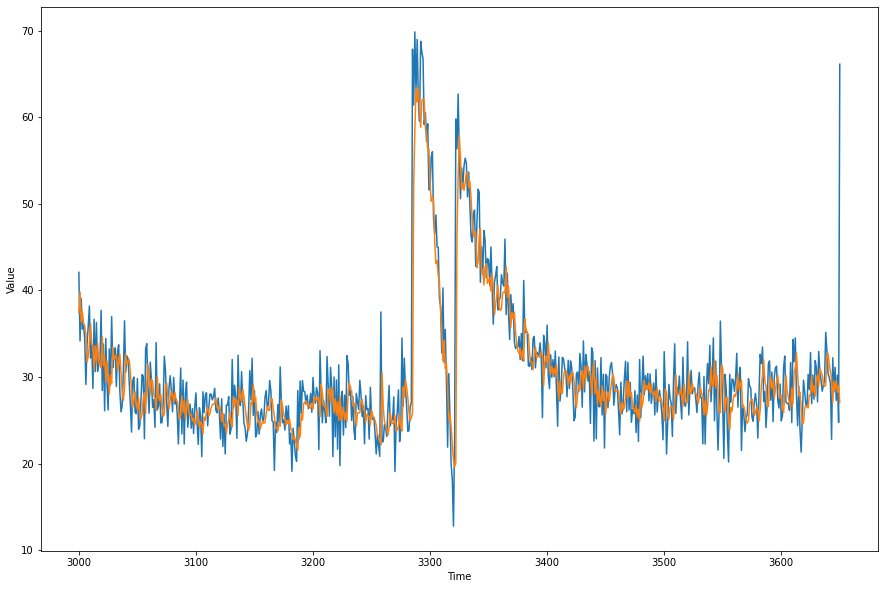

In [18]:
forecast = []
results = []
for time in tqdm(range(len(series) - window_size)):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(15, 10))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [19]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()   # YOUR RESULT HERE SHOULD BE LESS THAN 4

3.0237808

<Figure size 432x288 with 0 Axes>

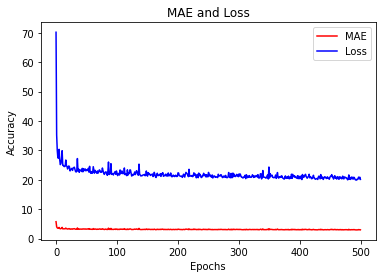

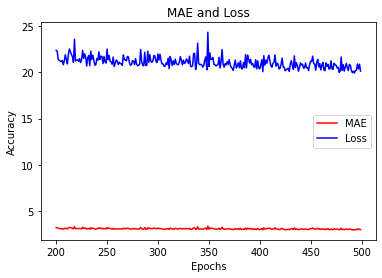

<Figure size 432x288 with 0 Axes>

In [20]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
mae=history.history['mae']
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs

#------------------------------------------------
# Plot MAE and Loss
#------------------------------------------------
plt.plot(epochs, mae, 'r')
plt.plot(epochs, loss, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()

epochs_zoom = epochs[200:]
mae_zoom = mae[200:]
loss_zoom = loss[200:]

#------------------------------------------------
# Plot Zoomed MAE and Loss
#------------------------------------------------
plt.plot(epochs_zoom, mae_zoom, 'r')
plt.plot(epochs_zoom, loss_zoom, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()